# Homework 4 - Hard coding

*Giacomo Ruà, Stefano D'Arrigo, Tansel Simsek*

---

## 1. Hashing 

In [13]:
import pandas as pd 
import numpy as np 
import random

from scripts.functions_q1 import *

In [3]:
data = pd.read_csv('dataset/hash.txt', nrows=100000, header=None)
data.head()

,0
0,844082e02a27ddee8d99ea1af94a2969
1,ff96d6665b5c59d3a70bb8f2ba4f10be
2,b64a85884e2b159829331c19e05dbac9
3,1c8836719e84867c26ba2cfeb372c53d
4,b66f73ffd9008d9c99159e164261df51


## Implement your hash function

We will define the hash function by extracting $32$ random integer coefficients in the range $[0, 2^{32}]$ and then multiplying the unicode order of each letter of a word in `data` by one of these random coefficients. 

For example: 

Consider the variable $word = f96d6$. The corresponding hash value will be: $h(word) = a_1 ord(f) + a_2 ord(9) + \dots + a_5 \dot ord(6) \, \, \, mod \, \,2^{32}$ (where $\, a_1, \dots, a_5$ are the random integer coefficients and $ord(\frac{}{})$ is the function that returns the number representing the unicode code of a specified character).  

So we first import these random integers. 

In [4]:
coeff = random.sample (range(0, pow(2, 32)), 32)

In [5]:
print(coeff)

[1495913670, 2494914436, 3629594379, 462924339, 129037699, 3663706410, 1775006604, 465749508, 3739530584, 3528863988, 1159522304, 365817859, 64677635, 451980273, 4065113625, 2168423046, 3228375236, 1392809683, 543191290, 2259770495, 2240594080, 217189528, 1336970702, 2547491218, 1230781685, 192575032, 2957931932, 370434761, 2156446824, 2398149766, 179185311, 3029173623]


Here an example: 

In [12]:
hash_function('b66f73ffd9008d9c99159e164261df51', coeff)

3331969535

## Implement a HyperLogLog structure 

We will implement a **6-bit HyperLogLog** structure, therefore we will take the first $6$ bits of the binary representation of the hash value as bucket number. 

For example: 


Consider the number: $100100101010101000$. 

We will use $\textbf{100100}101010101000$ as the bucket number in which we will put the position of the rightmost $1$ (i.e. $10010010101010\textbf{1}000 \,$) . Therefore in this case we will have `buckets[36] = 3` . 



In [8]:
buckets = hyperLogLog(data, coeff)

## Cardinality & Error

In [10]:
cardinality_hyperLogLog(buckets)

96536.0072553893

Therefore the error of the filter will be: $3.4 \%$

## 2. Clustering

In [32]:
from tqdm import tqdm
from scipy.stats import ttest_ind

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD # for features reduction

from scripts.functions_q2 import *

### Data 

#### Description and exploration

The dataset [*Amazon Fine Food Reviews*](https://www.kaggle.com/snap/amazon-fine-food-reviews) we are working on contains the plain text of the reviews about fine food on Amazon - gathered from Oct 1999 to Oct 2012 - and the metadata associated with them. Specifically, the dataset has the following columns:  

- Id -> identifies each review
- ProductId -> identifies each product
- UserId -> identifies the author of the review
- ProfileName -> the username of the author; may be not present
- HelpfulnessNumerator -> number of users that considered the review helpful
- HelpfulnessDenominator -> number of users who judged the review helpful or not helpful
- Score -> score given to the product reviewed 
- Time -> timestamp of the review, in UNIX format
- Summary -> brief summary of the content of the review
- Text -> plain text of the review

First and foremost, we explore the dataset:

In [2]:
dataset = pd.read_csv('data/Reviews.csv')
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

As we can see, there are few data missing in the dataset. We replace the missing values in the `Summary` column with an empty string.

In [5]:
dataset['Summary'].fillna('', inplace=True)

### Data pre-processing

Before applying K-means on the dataset, it is worth to pre-process the text, in order to denoise the data and reduce the number of features. Thi last point is crucial, since the K-means algorithm suffers of the curse of dimensionality. 

The first step, as usual, is to get rid of the few informative words from the text. To do this, we write the following function:

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


def clean_text(text, stop_words, parts_of_speech, lemmatizer):
    words_list = pos_tag(word_tokenize(text))
    result_words = []
    for word, pos in words_list:
        if (word.lower() not in stop_words) and word.isalpha() and (pos[0] in parts_of_speech):
            result_words.append(lemmatizer.lemmatize(word.lower(), pos=parts_of_speech[pos[0]]))
    return ' '.join(result_words)

Specifically, the function above transforms into lower case the words in the text, gets rid of the words that contain non alphabetical characters, lemmatizes and tags the words and filters the text according to part of speech tag assigned to each word. 

We extend the standard `nltk` stop words list with a custom list of adjectives related to opinion expression; indeed, opinion adjectives are not related to the specific kind of product, but only with the experience customers had with the product; then, these adjectives don't add any information about the kind of products and rather they are a sort of noise across the products' reviews. The list of opinion adjectives is available [here](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

Furthermore, since we are trying to reduce the dimensionality of the feature set as much as possible with the minimum information loss, we filter out all the words that are not nouns, verbs or adjectives; actually, we reckoned that pronouns, articles, adverbs and so on give us few or no information about the review's topic.

Before processing the text, we merge the reviews' text with their summary. Indeed the summary often contains useful words we may want to retain.

In [7]:
dataset['Text'] = dataset[['Summary', 'Text']].agg(' '.join, axis=1)

In [8]:
with open('./data/opinion-lexicon-English/negative-words.txt', 'r') as neg_file:
    sentiment_words = neg_file.readlines()

with open('./data/opinion-lexicon-English/positive-words.txt', 'r') as pos_file:
    sentiment_words += pos_file.readlines()

sentiment_words = [w.rstrip('\n') for w in sentiment_words] # clean the words from the \n char

kargs = {'lemmatizer': WordNetLemmatizer(),
         'stop_words': dict.fromkeys(stopwords.words('english') + sentiment_words),
         'parts_of_speech': {'N':'n', 'V':'v', 'J':'a'}
        }

dataset['Text'] = dataset.Text.apply(clean_text, **kargs)

Text cleaning left us with a bunch of blank rows. Checking them in the original dataset, we found that the text of these reviews was not informative at all, cause it contained only opinions, without the products' specifications. Then, we discard these rows from the text analysis.

In [9]:
dataset[dataset.Text == '']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59774,59775,B001NZW2V6,A3J5IKBQOHNJ8G,"S. Griffith ""truth reader""",0,1,5,1317859200,love them,
168550,168551,B0001ES9F8,A33Q5O9WGJUKWN,Seth Goldstein,0,0,5,1137283200,good,
221173,221174,B0016P26CS,A185D3IQUWHMTH,Marie,6,6,5,1271548800,Very good!,
233938,233939,B003E6COMO,A2ZE58VIDDCMR7,inna,1,2,5,1350000000,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...,
453668,453669,B0001QYYUK,A3S7N11XRRTUU6,Bob,5,14,1,1136246400,Not worth it,


In [10]:
dataset = dataset[dataset.Text != '']

Since the text pre-processing takes several minutes to be done, we save the pre-processed text in a new file, so that we can load fastly then: 

In [11]:
dataset.to_csv('data/Reviews_processed.csv', index=False)

In [3]:
dataset = pd.read_csv('/Users/tanselsimsek/Desktop/DS/Algorithmic Methods of Data Mining/HWs/adm_hw4/Reviews_processed.csv')

In [4]:
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,quality dog food buy several vitality can food...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,advertised product arrive label jumbo salted p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",say confection century light pillowy citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,cough medicine look secret ingredient robituss...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,taffy taffy price wide assortment yummy taffy ...


<br>

Before filtering the dataframe, for the future analysis, the following dataframe will be created in order to trace number of unique users writing reviews in each `ProductId`. product_id_to_unique_users dictionary contains key as `ProductId`'s values as number of unique users writing review for each `ProductId`.

In [5]:
unique_product_id = dataset.ProductId.unique()
product_id_to_unique_users = {}
for i in tqdm(range(len(unique_product_id))):
    product_id_to_unique_users[unique_product_id[i]] = dataset[dataset.ProductId == unique_product_id[i]].ProfileName.nunique()

100%|██████████| 74258/74258 [34:08<00:00, 36.26it/s]


<br>

Following variable is constructed in order to analyse reviews' score distribution in each cluster. While key contains unique `ProductId`'s, values contain average score of the correcponding `ProductId`.

In [6]:
product_id_to_avg_reviews_score = {}
for i in tqdm(range(len(unique_product_id))):
    product_id_to_avg_reviews_score[unique_product_id[i]] = dataset[dataset.ProductId == unique_product_id[i]].Score.mean()

100%|██████████| 74258/74258 [34:42<00:00, 35.66it/s]


<br>

Now, having processed the reviews' content, we aggregate them by the `ProductId`; this way, we obtain a dataset of products associated with their reviews and we can cluster them according to the text.

In [11]:
dataset = dataset.loc[:, ('ProductId', 'Text')]
dataset = dataset.groupby('ProductId')['Text'].agg(lambda x: ' '.join(x)).reset_index()
dataset.head()

,ProductId,Text
0,0006641040,read read read chicken soup rice day person sa...
1,141278509X,drink mix product archer farm drink mix mix fl...
2,2734888454,make china dog chicken product china wont buy ...
3,2841233731,recipe book babycook book read ingredient stor...
4,7310172001,product health snack pup make beef liver puppy...


At this point dataframes with number of unique users wrote review and review's average score for each `ProductId` can be constructed.

In [12]:
user_num_list = []
for i in range(len(dataset)):
    user_num_list.append(product_id_to_unique_users[dataset.ProductId.iloc[i]])
dataset_with_users = dataset.copy()
dataset_with_users['NumberOfUsers'] = user_num_list
dataset_with_users

,ProductId,Text,NumberOfUsers
0,0006641040,read read read chicken soup rice day person sa...,37
1,141278509X,drink mix product archer farm drink mix mix fl...,1
2,2734888454,make china dog chicken product china wont buy ...,2
3,2841233731,recipe book babycook book read ingredient stor...,1
4,7310172001,product health snack pup make beef liver puppy...,167
...,...,...,...
74253,B009UOFTUI,coffee premium product price coffee premium ta...,1
74254,B009UOFU20,coffee premium product price coffee premium ta...,1
74255,B009UUS05I,basket sympathy gift try express much care pro...,1
74256,B009WSNWC4,purchase product local store ny kid quick meal...,1


In [13]:
score_list = []
for i in range(len(dataset)):
    score_list.append(product_id_to_avg_reviews_score[dataset.ProductId.iloc[i]])
dataset_with_avg_score = dataset.copy()
dataset_with_avg_score['Average_Score'] = score_list
dataset_with_avg_score

,ProductId,Text,Average_Score
0,0006641040,read read read chicken soup rice day person sa...,4.351351
1,141278509X,drink mix product archer farm drink mix mix fl...,5.000000
2,2734888454,make china dog chicken product china wont buy ...,3.500000
3,2841233731,recipe book babycook book read ingredient stor...,5.000000
4,7310172001,product health snack pup make beef liver puppy...,4.751445
...,...,...,...
74253,B009UOFTUI,coffee premium product price coffee premium ta...,1.000000
74254,B009UOFU20,coffee premium product price coffee premium ta...,1.000000
74255,B009UUS05I,basket sympathy gift try express much care pro...,5.000000
74256,B009WSNWC4,purchase product local store ny kid quick meal...,5.000000


At this point, it is possible to compute the document-term matrix. Following the results and the conclusions in [[1]](#r:1), [[2]](#r:2), [[3]](#r:3), we decided to represent the reviews using a TF-IDF representation instead of a binary representation; indeed, to discriminate the topic of each review, it is worth to consider which words are the most informative and which are almost noise, i.e. which are present in many reviews and then no discriminative.

To compute the document-term matrix (i.e. the product-term matrix), we leverage the `TfidfVectorizer` object of the `sklearn` library.

As a first step for noise reduction, we specify in the constructor of `TfidfVectorizer` the parameter `max_df`, which allows us to filter out the words that appear in a fraction of the documents grater than the one specified; doing this, we discard the words that are stop words in our specific corpus of documents. 

Then, with the parameter `min_df` we also discard those words that are very rare and thus that may alter too much the vector representation of the documents in the space. After many tries, we found that good values for these parameters are `max_df=0.5` and `min_df=0.5`.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer # document vectorization and TF-IDF

vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, use_idf=True) # word associated to less than 5 products
docterm_mat = vectorizer.fit_transform(dataset['Text'])

In [15]:
docterm_mat.shape[1] # number of features, that is number of words in the vocabulary

28295

As we can see, the number of features, that is the number of components of the vectors that represent the documents, is still huge.

To dramatically reduce the number of features, we apply the SVD method to the document-term matrix. We start trying with a number of components equal to 100, as suggested, and increasing this number until at least the 60% of the initial variance is retained.

100%|██████████| 9/9 [05:33<00:00, 37.07s/it]


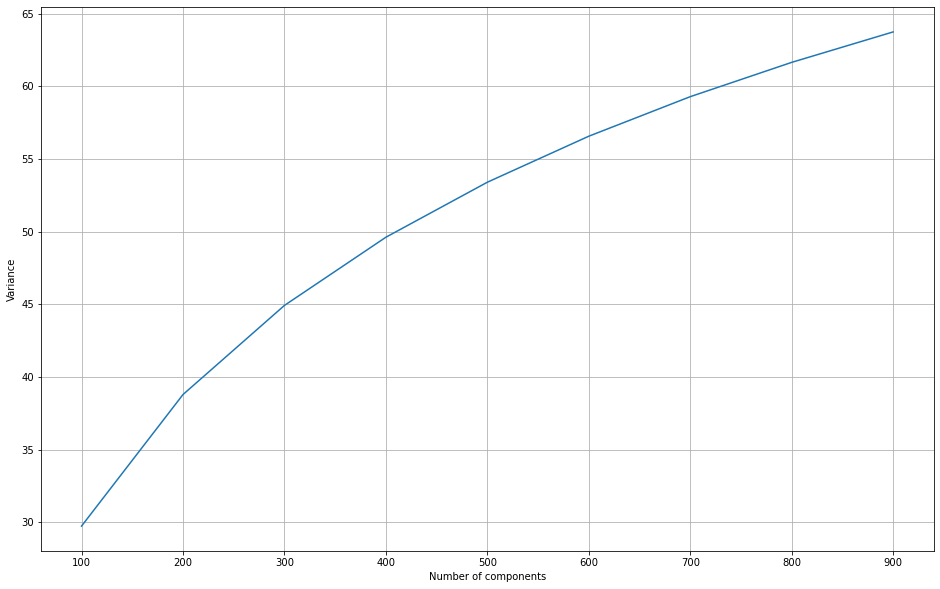

In [16]:
estimate_components(docterm_mat, 100, 1000, 100)

According to the plot above, the 60% of the variance corresponds to about 780 components. Because the plot was computed taking into account an increment of 100 components at each step and then it is an approximation, we pick 800 components, which guarantee to have more than the 60% of the variance.

As pointed out in [[4]](#r:4), K-means is known to work better on normalized features; then we pipeline the SVD method with a normalization, as in the official `sklearn` documentation. 

In [17]:
svd = TruncatedSVD(n_components=800)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
reduced = lsa.fit_transform(docterm_mat)

In [18]:
print(f'Variance with 800 components:\t{round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100}%')

Variance with 800 components:	61.650000000000006%


In the next section, we implement K-means and we apply it on the reduced matrix of products-terms.

<br>

### 2.1 K-means

In this section, we first implement K-means from scratch. In order to keep this notebook agile to read, for K-means implementation check in the file `scripts/functions_q2.py`.

After having implemented the algorithm, we find the optimal number of clusters throughout the elbow method.

In [20]:
elbow = elbow_method(reduced, end_n=111)

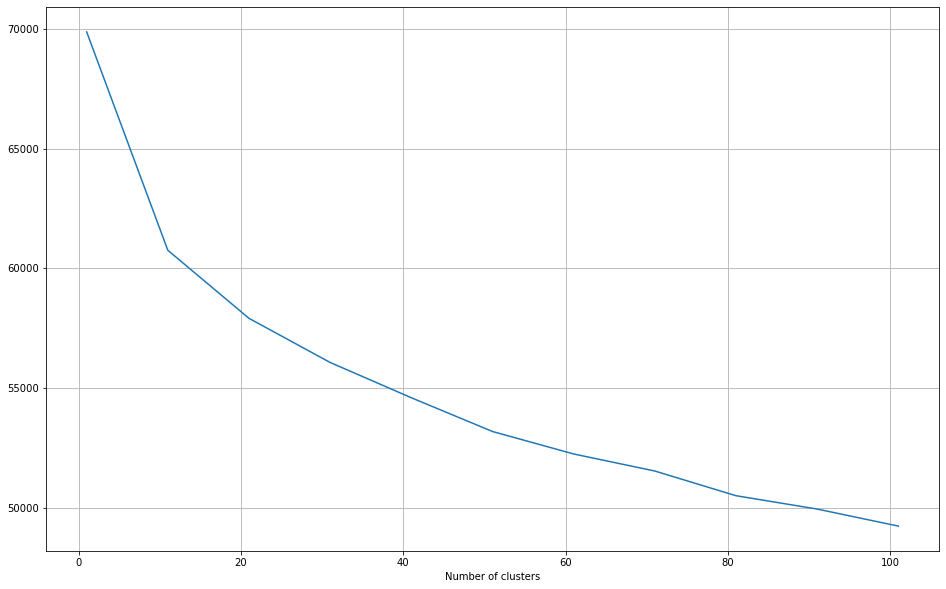

In [31]:
plot_elbow(elbow)

Even though different preprocessing methods were applied to clearly prepare the vocabulary, the plot for detecting elbow doesn't show satisfactory shape to decide on optimal k. 

Thus, different k values were used to test the performance of number of clusters in word cloud scheme (section 2.3.1) to find optimal k value. After many tries, the most satisfying k value is found as 23.

### 2.2 Comparison between k-means and k-means++ algorithms

In [19]:
k = 23

In [20]:
cluster_dict, center_matrix = k_means(k, reduced)

In [21]:
from sklearn.cluster import KMeans

k_means_plus = KMeans(n_clusters=k)
fit_pred = k_means_plus.fit_predict(reduced)
center_matrix_plus = k_means_plus.cluster_centers_
cluster_dict_plus ={}
for i in range(k):
    cluster_dict_plus[i]=[]
for i in range(len(fit_pred)):
    cluster_dict_plus[fit_pred[i]].append(i)

#### Inertia of k-means and k-means++

In [22]:
# Inertia for k-means algorithm
compute_inertia(cluster_dict, center_matrix, reduced)

57931.682068250106

In [23]:
# Inertia for k-means++ algorithm
compute_inertia(cluster_dict_plus, center_matrix_plus, reduced)

57504.72218697026

In [24]:
# inertia(k-means)/inertia(k-means++)
compute_inertia(cluster_dict, center_matrix, reduced)/compute_inertia(cluster_dict_plus, center_matrix_plus, reduced)

1.007424779479703

Low inertia value is interpreted as a good sign of the centroid allocation in k-means algorithms. Comparison of inertia values between k-means and k-means++ algorithm shows that k-means has slightly higher inertia than the k-means++ algorithm. This increase is found as .007 which is very low amount to say that k-means performs significantly worse than the k-means++. Under the consideration of random initialization, this difference can be explained. Also, it is better to state that another run for k-means does not guarantee an optimistic scenario like this case.

#### Average distance between centroids in k-means and k-means++

In [25]:
distance_list=[]
for i in range(len(center_matrix)):   
    for j in range(len(center_matrix)):
        if i !=j:
            distance_list.append(np.linalg.norm(center_matrix[i]-center_matrix[j]))
sum(distance_list)/len(distance_list)

0.7265317750609378

In [26]:
distance_list=[]
for i in range(len(center_matrix_plus)):   
    for j in range(len(center_matrix_plus)):
        if i !=j:
            distance_list.append(np.linalg.norm(center_matrix_plus[i]-center_matrix_plus[j]))
sum(distance_list)/len(distance_list)

0.732339314084909

It can be seen that average distance between centroids has larger amount in k-means++ than the k-means algorithm. High distance value between the centroids is a good sign of the fitted model. It can be also seen that, found values show support of good fit in the k-means algorithm. We can say that random initialization does not lead bad centroid allocation for this case.

### 2.3 Analyse the obtained clusters

#### 2.3.1 Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

At this point, using the word cloud representation we see the topic of each cluster.

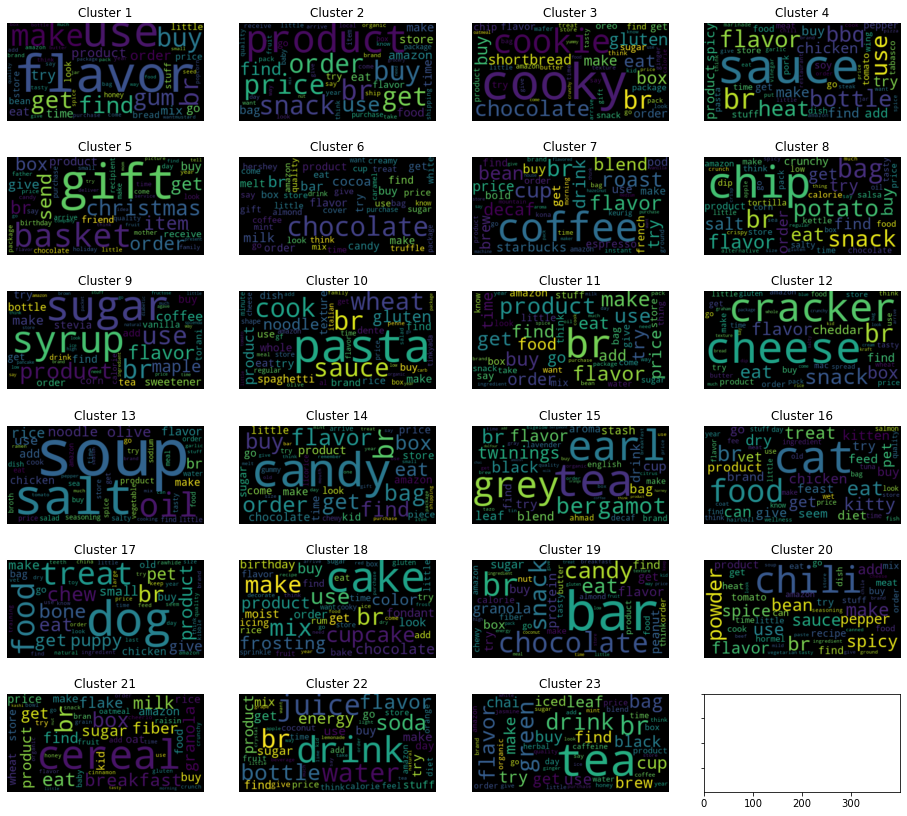

In [27]:
get_word_cloud(center_matrix, svd, vectorizer)

Looking at the representation, we can reasonably say that the majority of the clusters makes sense. However, some of them contain very generic words, such as clusters 1, 2, 11. We reckon that these meaningless clusters are related to the absence of an evident elbow in the elbow method plot. 

#### 2.3.2 Provide the number of product in each cluster

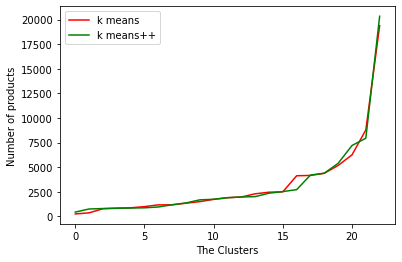

In [28]:
# Cluster size for each cluster in sorted order for k-means
cluster_size = []
for i in cluster_dict:
    cluster_size.append(len(cluster_dict[i]))
cluster_size.sort()

# Cluster size for each cluster in sorted order for k-means++
cluster_size_plus = []
for i in cluster_dict_plus:
    cluster_size_plus.append(len(cluster_dict_plus[i]))
cluster_size_plus.sort()

plt.plot(cluster_size, 'r')
plt.plot(cluster_size_plus, 'g')
plt.xlabel("The Clusters")
plt.ylabel("Number of products")
legend = ['k means', 'k means++']
plt.legend(legend)
plt.show()

From the above plot, number of elements in the clusters for k-means and k-means++ algorithms are found close to each other. In order to have a nice-shaped graph and make an easy comparies both data are sorted.

#### 2.3.3 Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!

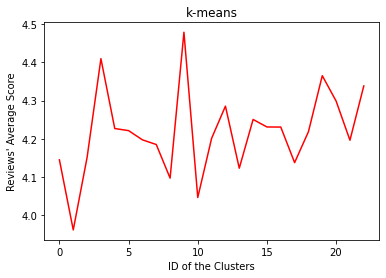

In [29]:
avg_score_in_each_cluster_k_means = [0] * k
for i in range(k):
    for j in range(len(cluster_dict[i])):
        avg_score_in_each_cluster_k_means[i] += dataset_with_avg_score.iloc[cluster_dict[i][j]].Average_Score
    avg_score_in_each_cluster_k_means[i] /= len(cluster_dict[i])

plt.plot(avg_score_in_each_cluster_k_means, 'r')
plt.xlabel("ID of the Clusters")
plt.ylabel("Reviews' Average Score")
plt.title('k-means')
plt.show()

Above plot is created to observe the Reviews' Average Score by ID of the clusters in k-means algorithm. Range varies between 4.4 to 3.7, 14% range distance shows a good distribution of the reviews between clusters.

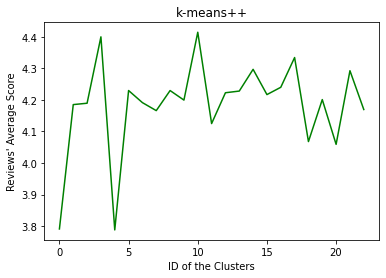

In [30]:
avg_score_in_each_cluster_k_means_plus = [0] * k
for i in range(k):
    for j in range(len(cluster_dict_plus[i])):
        avg_score_in_each_cluster_k_means_plus[i] += dataset_with_avg_score.iloc[cluster_dict_plus[i][j]].Average_Score
    avg_score_in_each_cluster_k_means_plus[i] /= len(cluster_dict_plus[i])

plt.plot(avg_score_in_each_cluster_k_means_plus, 'g')
plt.xlabel("ID of the Clusters")
plt.ylabel("Reviews' Average Score")
plt.title('k-means++')
plt.show()

Above plot is created to observe the Reviews' Average Score by ID of the clusters in k-means++ algorithm. Range varies between 4.47 to 3.6, 17% range distance shows a good distribution of the reviews between clusters.

In the below, distribution comparison can be found for both k-means and k-means++ algorithms and cluster by cluster:

In [33]:
clusters_k_means = []
for i in range(k):
    cluster = []
    for j in range(len(cluster_dict[i])):
        cluster.append(dataset_with_avg_score.iloc[cluster_dict[i][j]].Average_Score)
    clusters_k_means.append(cluster)

clusters_k_means_plus = []
for i in range(k):
    cluster = []
    for j in range(len(cluster_dict_plus[i])):
        cluster.append(dataset_with_avg_score.iloc[cluster_dict_plus[i][j]].Average_Score)
    clusters_k_means_plus.append(cluster)

# 1 for same distributions (fail to reject H0) , 0 for different distributions (reject H0)
def compare_2_groups(arr_1, arr_2, alpha):
    stat, p = ttest_ind(arr_1, arr_2)
    if p > alpha:
        return 1
    else:
        return 0

hyp_test = np.zeros([k,k])
for i in range(k):
    for j in range(k):
        hyp_test[i][j] = compare_2_groups(clusters_k_means[i], clusters_k_means[j], 0.05)
hyp_test_df = pd.DataFrame(hyp_test)
number_of_dist = []
for i in range(k):
    number_of_dist.append(sum(hyp_test_df.iloc[i])-1)
hyp_test_df['number of same distribution'] = number_of_dist

hyp_test_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,number of same distribution
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,11.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
4,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,13.0
5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0
6,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,11.0
7,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,13.0
8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 2.3.4 Get the number of unique users writing reviews in each cluster

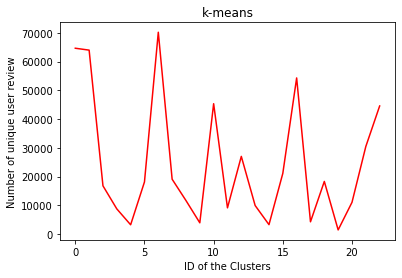

In [34]:
total_users_in_each_cluster_k_means = [0] * k
for i in range(k):
    for j in range(len(cluster_dict[i])):
        total_users_in_each_cluster_k_means[i] += dataset_with_users.iloc[cluster_dict[i][j]].NumberOfUsers

plt.plot(total_users_in_each_cluster_k_means, 'r')
plt.xlabel("ID of the Clusters")
plt.ylabel("Number of unique user review")
plt.title('k-means')
plt.show()

Above plot, there can be seen the total number of unique users writing reviews for each cluster ID in k-means method.

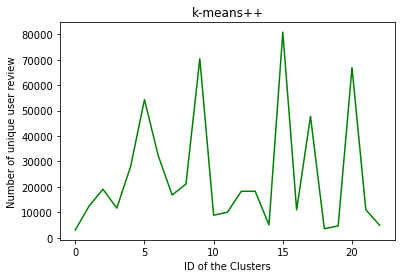

In [36]:
total_users_in_each_cluster_k_means_plus = [0] * k
for i in range(k):
    for j in range(len(cluster_dict_plus[i])):
        total_users_in_each_cluster_k_means_plus[i] += dataset_with_users.iloc[cluster_dict_plus[i][j]].NumberOfUsers

plt.plot(total_users_in_each_cluster_k_means_plus, 'g')
plt.xlabel("ID of the Clusters")
plt.ylabel("Number of unique user review")
plt.title('k-means++')
plt.show()

Above plot is created to show the total number of unique users writing reviews for each cluster ID in k-means++ algorithm.

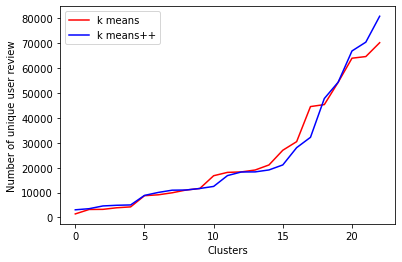

In [37]:
total_users_in_each_cluster_k_means.sort()
total_users_in_each_cluster_k_means_plus.sort()

plt.plot(total_users_in_each_cluster_k_means, 'r')
plt.plot(total_users_in_each_cluster_k_means_plus, 'b')
plt.xlabel("Clusters")
plt.ylabel("Number of unique user review")
legend = ['k means', 'k means++']
plt.legend(legend)
plt.show()

The upper plot shows the relation between k-means and k-means++ algorithm. Since Cluster ID's cannot be in the same order, in order to have a better plot, number of unique user reviews is sorted in both method. It can be observed that, similarly to other graphs, k-means and k-means++ algorithms contain pretty close number of unique user reviews for the clusters.    

<br>

## 3. Algorithmic question

**Theorem.** Let $A$ be an array of $n$ integers and let $s$ and $b$ be the minimum $\min\{A\}$ and the maximum $\max\{A\}$ of $A$, respectively.

Then, defined $r = b - s$, we can prove that $A$ can be sorted in $\mathbf{O}(n+r)$ time.

**Proof.**

To prove this statement, let us consider the *Counting sort* algorithm, which assumes that it is given as input a set of integers in the range $[h,h+k]$, $\forall h,k\in \mathbb{N}$ where $h \lt k$. Then, for each number $x$, it determines how many elements are less than $x$ and places $x$ into the right position in the output array. It requires an extra array $C$ of dimension $r$.

![](utils/counting_sort.png)

Analyzing the algorithm, lines $1$ and $2$, i.e. the research of the minimum and the maximum of $A$, take $\mathbf{O}(n)$ each. Scanning $C$ takes $\mathbf{O}(r)$ and placing the sorted numbers in $B$ takes again $\mathbf{O}(n)$. Then, the overall complexity of *Counting Sort* is $\mathbf{O}(n) + \mathbf{O}(r) = \mathbf{O}(n+r)$.

In the end, we have proved that $A$ can be sorted in $\mathbf{O}(n+r)$.

**Note:** due to some Latex visualization issues related to the render engine of GitHub, the Latex output was included as an image. The complete source of this answer can be found in `utils/Algorithmic_question.ipynb`.

---

## References

<div id='r:1'>[1] V. K. Singh, N. Tiwari and S. Garg, "Document Clustering Using K-Means, Heuristic K-Means and Fuzzy C-Means," 2011 International Conference on Computational Intelligence and Communication Networks, Gwalior, 2011, pp. 297-301, doi: 10.1109/CICN.2011.62.</div><br>

<div id='r:2'>[2] Anna Huang, "Similarity Measures for Text Document Clustering", NZCSRSC 2008, April 2008, Christchurch, New Zeland, doi: 10.1.1.332.4480.</div><br>

<div id='r:3>[3]'>[3] Lucas de Sá, "Text Clustering with K-Means", Medium, Dec 18 2019,  https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b</div><br>

<div id='r:4'>[4] "Clustering text documents using k-means", ScikitLearn, https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py</div><br>

<div id='r:5'>[5] T.H. Cormen, C.E. Leiserson, R.L. Rivest, C. Stein, "Introduction to algorithms", MIT press</div>